<div class="alert alert-danger" role="alert">
    <span style="font-size:20px">&#9888;</span> <span style="font-size:16px">This is a read-only notebook! If you want to make and save changes, save a copy by clicking on <b>File</b> &#8594; <b>Save a copy</b>. If this is already a copy, you can delete this cell.</span>
</div>

<h1>Using Great Circle distance and clustering to find nearby locations<span class="tocSkip"></span></h1>

This notebook helps calculates great circle distances between all pairs of locations, and then runs hierarchical clustering to identify clusters of locatoins. This uses Latitude and Longitude information -- if you only have street addresses, you need to geocode them, see the HERE Maps API for examples. 

The distance calculations functions are defined within the notebook. In future versions, we will move them to the utilities folder into re-usable .py files.

For questions, email daniel.wang@oliverwyman.com



<h1>Table of Contents<span class="tocSkip"></span></h1>

<ul class="toc-item"><li><span><a href="#Load-in-dataset" data-toc-modified-id="Load-in-dataset-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load in dataset</a></span></li><li><span><a href="#Calculate-Great-Circle-distance-matrix" data-toc-modified-id="Calculate-Great-Circle-distance-matrix-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Calculate Great Circle distance matrix</a></span></li><li><span><a href="#Convert-into-a-distance-matrix" data-toc-modified-id="Convert-into-a-distance-matrix-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Convert into a distance matrix</a></span></li><li><span><a href="#Run-hierarchical-clustering" data-toc-modified-id="Run-hierarchical-clustering-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Run hierarchical clustering</a></span><ul class="toc-item"><li><span><a href="#Convert-into-a-condensed-distance-vector" data-toc-modified-id="Convert-into-a-condensed-distance-vector-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Convert into a condensed distance vector</a></span></li><li><span><a href="#Run-hierarchical-clustering" data-toc-modified-id="Run-hierarchical-clustering-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Run hierarchical clustering</a></span></li></ul></li><li><span><a href="#Examine-cluster-outputs" data-toc-modified-id="Examine-cluster-outputs-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Examine cluster outputs</a></span><ul class="toc-item"><li><span><a href="#Get-cluster-assignment-for-each-item" data-toc-modified-id="Get-cluster-assignment-for-each-item-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Get cluster assignment for each item</a></span></li><li><span><a href="#Merge-in-the-lat-longs-and-names" data-toc-modified-id="Merge-in-the-lat-longs-and-names-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Merge in the lat longs and names</a></span></li><li><span><a href="#Plot-on-a-grid" data-toc-modified-id="Plot-on-a-grid-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Plot on a grid</a></span></li><li><span><a href="#Plot-on-a-map" data-toc-modified-id="Plot-on-a-map-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Plot on a map</a></span></li></ul></li></ul>

In [4]:
import pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

# Load in dataset

In [5]:
dataset = pd.read_csv("campsites.csv")

In [6]:
dataset.head()

,FacilityID,CampsiteName,CampsiteLongitude,CampsiteLatitude
0,232446,65,-119.683914,37.550125
1,232447,44,-119.565040,37.737625
2,232451,78,-119.866541,37.799589
3,232709,9,-97.264983,31.586164
4,251938,32,-84.485965,35.076028


# Calculate Great Circle distance matrix

In [7]:
# Generic function for calculating great circle distance, vectorized
def great_circle_distance(lon1, lat1, lon2, lat2, unit='miles'):
    """    
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """

    # convert decimal degrees to radians    
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])    # haversine formula    
    dlon = lon2 - lon1    
    dlat = lat2 - lat1    
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2    
    c = 2 * np.arcsin(np.sqrt(a))    
    
    if unit in ["miles", "mile"]:
        r = 3958.756 # Radius of earth in miles
    elif unit in ["km", "kilometer", "kilometers"]:
        r = 6371.0 # Radius of earth in kms

    return c * r

# Function for getting closest distance only.  
def get_all_distances(origin, targets, lon_column="Lon", lat_column="Lat", unit='miles', append_origin=False):
    """
    Great circle distance between an origin (single row in dataframe) and a dataframe with target destinations. 
    lon_column is the column name containing Longitude
    lat_column is the column name containing Latitude
    append_origin should be true to add the origin information
    """
    
    targets = targets.copy()
    
    targets['great_circle_distance'] = great_circle_distance(origin[lon_column], origin[lat_column], 
                                                             targets[lon_column], targets[lat_column])
    
    
    if append_origin:
        for col in origin.index:
            targets["Origin: {}".format(col)] = origin[col]

    return targets



In [8]:
output_list = []

nrows = dataset.shape[0]
for index, row in dataset.iterrows():
    
    if index % 100==0: print("Processing {} out of {} items".format(index+1, nrows+1))
    
    result = get_all_distances(row, targets = dataset, lon_column="CampsiteLongitude", lat_column="CampsiteLatitude", unit='miles', append_origin=True)
    
    output_list.append(result)

Processing 1 out of 1001 items
Processing 101 out of 1001 items
Processing 201 out of 1001 items
Processing 301 out of 1001 items
Processing 401 out of 1001 items
Processing 501 out of 1001 items
Processing 601 out of 1001 items
Processing 701 out of 1001 items
Processing 801 out of 1001 items
Processing 901 out of 1001 items


In [9]:
distance_results = pd.concat(output_list)

In [10]:
distance_results.head()

,FacilityID,CampsiteName,CampsiteLongitude,CampsiteLatitude,great_circle_distance,Origin: FacilityID,Origin: CampsiteName,Origin: CampsiteLongitude,Origin: CampsiteLatitude
0,232446,65,-119.683914,37.550125,0.000000,232446,65,-119.683914,37.550125
1,232447,44,-119.565040,37.737625,14.495795,232446,65,-119.683914,37.550125
2,232451,78,-119.866541,37.799589,19.920727,232446,65,-119.683914,37.550125
3,232709,9,-97.264983,31.586164,1336.584156,232446,65,-119.683914,37.550125
4,251938,32,-84.485965,35.076028,1955.668387,232446,65,-119.683914,37.550125


# Convert into a distance matrix

In [11]:
distance_matrix = distance_results[['Origin: FacilityID', 'FacilityID', 'great_circle_distance']].pivot(index = 'Origin: FacilityID', columns='FacilityID', values='great_circle_distance')

In [12]:
distance_matrix.head()

FacilityID,15045,202155,231836,231837,231838,231840,231848,231852,231862,231864,...,10192122,10192127,10203811,10207636,10214673,10214711,10214735,10214768,10220609,10224635
Origin: FacilityID,,,,,,,,,,,,,,,,,,,,,
15045,0.000000,394.446783,369.344980,415.498394,405.717329,416.398833,327.607192,396.906008,402.130386,338.956347,...,758.314791,1094.227419,1612.461062,1580.235256,418.273895,477.545371,416.850996,414.529063,602.440602,1826.102682
202155,394.446783,0.000000,488.487761,481.948209,473.119120,488.918356,254.670213,266.004534,229.123836,230.285669,...,512.222091,1149.647135,1441.026749,1423.769622,25.215717,86.198112,23.910360,22.336580,551.170388,1710.941011
231836,369.344980,488.487761,0.000000,63.799725,59.352647,59.467244,238.534592,264.162698,302.926501,265.910588,...,987.051391,731.157973,1275.510194,1237.415296,510.807017,564.040181,509.896173,509.343973,923.811907,1466.898458
231837,415.498394,481.948209,63.799725,0.000000,10.416758,8.259847,227.280243,235.995957,276.849440,252.421888,...,989.240534,701.312974,1215.639197,1178.606829,502.583701,551.903110,501.817529,501.608391,947.169001,1413.186901
231838,405.717329,473.119120,59.352647,10.416758,0.000000,15.842945,218.506677,229.299570,269.964869,243.940034,...,979.872900,711.705392,1223.670245,1186.939027,493.921728,543.657139,493.141595,492.900629,936.816509,1422.467942


# Run hierarchical clustering

Read more here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html

## Convert into a condensed distance vector

In [13]:
distance_vector = sc.spatial.distance.squareform(distance_matrix)
distance_vector

array([ 394.44678342,  369.34498031,  415.49839355, ...,  546.20294452,
       1717.03789539, 2261.96034985])

## Run hierarchical clustering

In [14]:
cluster_output = sc.cluster.hierarchy.linkage(distance_vector, method='centroid')

# Examine cluster outputs

## Get cluster assignment for each item

In [25]:
cluster_assignment = sc.cluster.hierarchy.cut_tree(cluster_output, n_clusters=20, height=None)

In [26]:
clusters_assigned = pd.DataFrame({"FacilityID": distance_matrix.index, "Cluster": [x[0] for x in cluster_assignment]})
clusters_assigned.head()

,FacilityID,Cluster
0,15045,0
1,202155,1
2,231836,2
3,231837,2
4,231838,2


In [27]:
clusters_assigned['Cluster'].value_counts()

Cluster
7     302
1     179
4     130
5     106
0     104
6      67
3      49
8      27
9      10
2       9
13      6
10      5
14      1
15      1
16      1
17      1
18      1
19      1
Name: count, dtype: int64

## Merge in the lat longs and names

In [28]:
full_clusters = clusters_assigned.merge(dataset, on = 'FacilityID', how='left')

In [29]:
full_clusters

,FacilityID,Cluster,CampsiteName,CampsiteLongitude,CampsiteLatitude
0,15045,0,A-1,-111.853544,43.961886
1,202155,1,Hunter Canyon Group Site,-109.597027,38.510336
2,231836,2,24,-104.423472,44.426862
3,231837,2,5,-103.512620,43.775080
4,231838,2,3,-103.713975,43.735366
...,...,...,...,...,...
995,10214711,1,1,-109.608969,37.262811
996,10214735,1,1,-109.631466,38.165333
997,10214768,1,1,-109.669222,38.192051
998,10220609,7,HORSE #1 (HORSES ARE MANDATORY),-119.653589,37.539277


## Plot on a grid

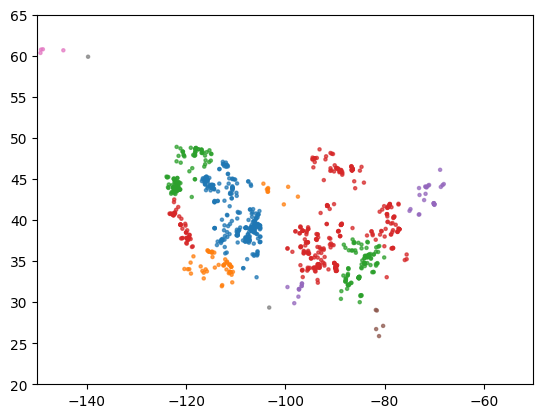

In [37]:
plt.scatter(full_clusters['CampsiteLongitude'], full_clusters['CampsiteLatitude'], c=full_clusters['Cluster'], 
            s = 5, # Size of scatter 
            alpha=0.7, # Transparency
            cmap = plt.colormaps.get_cmap('tab10') # Get more distinct colors. This cycles between 10 colors
           ) 
            
plt.xlim(-150, -50)  # Set x-axis limits
plt.ylim(20, 65)  # Set y-axis limits
plt.show()

## Plot on a map

You need mpl_toolkits to plot the map

In [31]:
from mpl_toolkits.basemap import Basemap

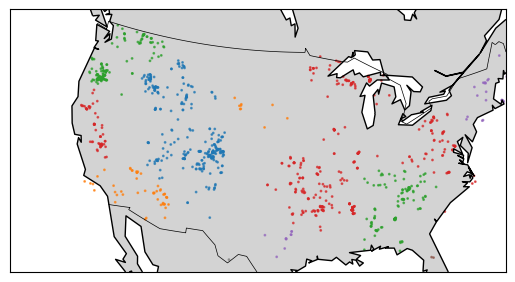

In [36]:
# Create a basemap instance for the United States
map = Basemap(llcrnrlon=-125, llcrnrlat=24, urcrnrlon=-66, urcrnrlat=50, projection='lcc', lat_1=33, lat_2=45, lon_0=-95)

# Draw the map boundaries
map.drawcoastlines()
map.drawcountries()
map.fillcontinents(color='lightgray')

# Convert longitude and latitude to map coordinates
x, y = map(full_clusters['CampsiteLongitude'], full_clusters['CampsiteLatitude'])

# Scatter plot the data with color
map.scatter(x, y, c=full_clusters['Cluster'], s=1, alpha=0.7, 
            cmap = plt.colormaps.get_cmap('tab10')  # Get more distinct colors
           )

plt.show()